In [2]:
#used libraries
library(data.table)
library(Matrix)
library(tidyverse)
library(dplyr)
library(glmnet)
library(caret)
library(rpart)
library(randomForest)
library(e1071)
library(gbm)
library(DMwR)
library(ROSE)
library(pROC)

In [3]:
project_train <- read.csv("IE582_Fall20_ProjectTrain.csv")
project_test <- read.csv("IE582_Fall20_ProjectTest.csv")

In [4]:
#removing no variance data
project_train2 <- project_train[!names(project_train) %in% c("x18", "x37", "x50", "x52", "x57")] 
project_test2 <- project_test[!names(project_test) %in% c("x18", "x37", "x50", "x52", "x57")] 

In [5]:
#weight calculations for weighted trainings (0.5 values are modified)
model_weights <- ifelse(project_train$y == "a",
                        (1/table(project_train$y)[1]) * 0.5,
                        (1/table(project_train$y)[2]) * 0.5)

In [ ]:
#Model - Lasso Regression
set.seed(666)
lambda_seq = c(seq(0,0.01,by=0.0001)) #wide range for lambda
n_repeats=5
n_folds=10
lasso_grid = expand.grid(alpha=1,lambda=lambda_seq)
lasso_control=trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary, method = "repeatedcv", number = n_folds, repeats = n_repeats)                        
project_lasso_fit = train(y~ .,data=project_train2, method = "glmnet", weights = model_weights, metric = 'ROC', tuneGrid = lasso_grid,trControl = lasso_control) 
project_lasso_fit

In [ ]:
#Model - Decision Trees

set.seed(666)

DT_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary, method = "repeatedcv", number = n_folds, repeats = n_repeats) 
DT_grid <- expand.grid(cp=c(0.0005,0.01,0.05,0.005,0.001,0.007)) # cp grid parameters are changed each time

# minbucket is tried manually 
project_DT_fit1 <- train(y~ .,data=project_train2, method ="rpart", weights = model_weights, metric = 'ROC',tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=10))
project_DT_fit2 <- train(y~ .,data=project_train2, method ="rpart", weights = model_weights, metric = 'ROC',tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=8))
project_DT_fit3 <- train(y~ .,data=project_train2, method ="rpart", weights = model_weights, metric = 'ROC',tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=12))

project_DT_fit1
project_DT_fit2
project_DT_fit3

In [ ]:
#Model - Random Forest - weighted
set.seed(666)
RF_grid <- expand.grid(mtry = c(7)) #parameters are changed each time
n_repeats=5
n_folds=10
RF_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary,  method = "repeatedcv", number = n_folds, repeats = n_repeats) 
project_RF_fit <- train(y~ .,data=project_train2, method ="rf", weights = model_weights, metric = 'ROC',tuneGrid = RF_grid, trControl=RF_control)
project_RF_fit
project_RF_fit$finalModel

In [ ]:
#Model - Random Forest - up smote down
set.seed(666)
RF_grid <- expand.grid(mtry = c(3,5,7)) #parameters are changed each time
n_repeats=5
n_folds=10
RF_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary,  method = "repeatedcv", number = n_folds, repeats = n_repeats, sampling = "up")
#RF_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary,  method = "repeatedcv", number = n_folds, repeats = n_repeats, sampling = "smote")
#RF_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary,  method = "repeatedcv", number = n_folds, repeats = n_repeats, sampling = "rose")
project_RF_fit <- train(y~ .,data=project_train2, method ="rf", metric = 'ROC',tuneGrid = RF_grid, trControl=RF_control)
project_RF_fit
project_RF_fit$finalModel

In [ ]:
#Model - Random Forest - ROSE sampling
set.seed(666)
RF_grid <- expand.grid(mtry = c(7)) #parameters are changed each time
n_repeats=5
n_folds=10
RF_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary,  method = "repeatedcv", number = n_folds, repeats = n_repeats, sampling = "rose") 
project_RF_fit <- train(y~ .,data=project_train2, method ="rf", metric = 'ROC',tuneGrid = RF_grid, trControl=RF_control)
project_RF_fit
project_RF_fit$finalModel

In [ ]:
#Model - SGB weighted 
set.seed(1)
n_folds=10
n_repeats=5
SGB_grid <- expand.grid(interaction.depth=c(5,7), n.trees = c(400,600,800),shrinkage=c(0.01),n.minobsinnode =c(5,7)) #parameters are changed each time
SGB_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary,  method = "repeatedcv", number = n_folds, repeats = n_repeats)
project_SGB_fit <- train(y~ .,data=project_train2, method ="gbm", weights = model_weights, metric = 'ROC',tuneGrid = SGB_grid, trControl=SGB_control)
project_SGB_fit

In [ ]:
#Model - SGB up/down/smote
set.seed(1)
n_folds=10
n_repeats=5
SGB_grid <- expand.grid(interaction.depth=c(5,7), n.trees = c(400,600,800),shrinkage=c(0.01),n.minobsinnode =c(5,7)) #parameters are changed each time
SGB_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary,  method = "repeatedcv", number = n_folds, repeats = n_repeats, sampling = "up")
#SGB_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary,  method = "repeatedcv", number = n_folds, repeats = n_repeats, sampling = "down")
#SGB_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary,  method = "repeatedcv", number = n_folds, repeats = n_repeats, sampling = "smote")
project_SGB_fit <- train(Class~ .,data=project_train2, method ="gbm", metric = 'ROC',tuneGrid = SGB_grid, trControl=SGB_control)
project_SGB_fit

In [6]:
#creating outside up sampling (or down)
set.seed(1)
up_train <- upSample(x = project_train2[, -ncol(project_train2)],
                     y = project_train2$y)                         
table(up_train$Class) 

down_train <- downSample(x = project_train2[, -ncol(project_train2)],
                     y = project_train2$y)                         
table(down_train$Class) 


   a    b 
1565 1565 


  a   b 
509 509 

In [ ]:
#Model - SGB out up - or down
set.seed(1)
n_folds=10
n_repeats=5
SGB_grid <- expand.grid(interaction.depth=c(5,7), n.trees = c(1000),shrinkage=c(0.01),n.minobsinnode =c(5,8)) #parameters are changed each time
SGB_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary,  method = "repeatedcv", number = n_folds, repeats = n_repeats)
project_SGB_fit <- train(Class~ .,data=up_train, method ="gbm", metric = 'ROC',tuneGrid = SGB_grid, trControl=SGB_control)
#project_SGB_fit <- train(Class~ .,data=up_train, method ="gbm", metric = 'ROC',tuneGrid = SGB_grid, trControl=SGB_control)
project_SGB_fit

In [ ]:
#Model - creating smote and rose sampling 
set.seed(1)
smote_train <- SMOTE(y ~ ., data  = project_train2)                         
table(smote_train$y) 

rose_train <- ROSE(y ~ ., data  = project_train2)$data          
table(rose_train$y) 

In [ ]:
#Model - SGB out SMOTE (or ROSE)
set.seed(1)
n_folds=10
n_repeats=5
SGB_grid <- expand.grid(interaction.depth=c(5), n.trees = c(600),shrinkage=c(0.01),n.minobsinnode =c(5)) #parameters are changed each time
SGB_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary,  method = "repeatedcv", number = n_folds, repeats = n_repeats)
project_SGB_fit <- train(y~ .,data=smote_train, method ="gbm", metric = 'ROC',tuneGrid = SGB_grid, trControl=SGB_control)
#project_SGB_fit <- train(y~ .,data=rose_train, method ="gbm", metric = 'ROC',tuneGrid = SGB_grid, trControl=SGB_control)
project_SGB_fit

In [ ]:
#getting class predictions
pred_prob <- predict(project_SGB_fit, project_test2, type="prob")
pred_prob
predictions <- pred_prob$b
predictions
save(predictions, file = "myvector.rda") #save predictions as rda file
write.csv(predictions, file ="myfile2.csv", row.names=FALSE) #save predictions as csv file (personal use)

###  Best Result

In [ ]:
#Best Model
set.seed(1)
n_folds=10
n_repeats=5
SGB_grid <- expand.grid(interaction.depth=c(7), n.trees = c(800),shrinkage=c(0.01),n.minobsinnode =c(5))
SGB_control <- trainControl(verboseIter=TRUE, classProbs=TRUE, summaryFunction=twoClassSummary,  method = "repeatedcv", number = n_folds, repeats = n_repeats)
project_SGB_best <- train(Class~ .,data=up_train, method ="gbm", metric = 'ROC',tuneGrid = SGB_grid, trControl=SGB_control)

In [8]:
project_SGB_best

Stochastic Gradient Boosting 

3130 samples
  55 predictor
   2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 2818, 2818, 2817, 2817, 2817, 2817, ... 
Resampling results:

  ROC        Sens       Spec     
  0.9316653  0.8174833  0.8886894

Tuning parameter 'n.trees' was held constant at a value of 800
Tuning

Tuning parameter 'shrinkage' was held constant at a value of 0.01

Tuning parameter 'n.minobsinnode' was held constant at a value of 5

,var,rel.inf
x23,x23,29.59791331
x30,x30,12.25562644
x32,x32,10.60814228
x42,x42,7.22517355
x14,x14,6.21438005
x10,x10,4.99550095
x27,x27,3.65699855
x9,x9,3.59476297
x11,x11,2.57621195
x48,x48,2.43012470


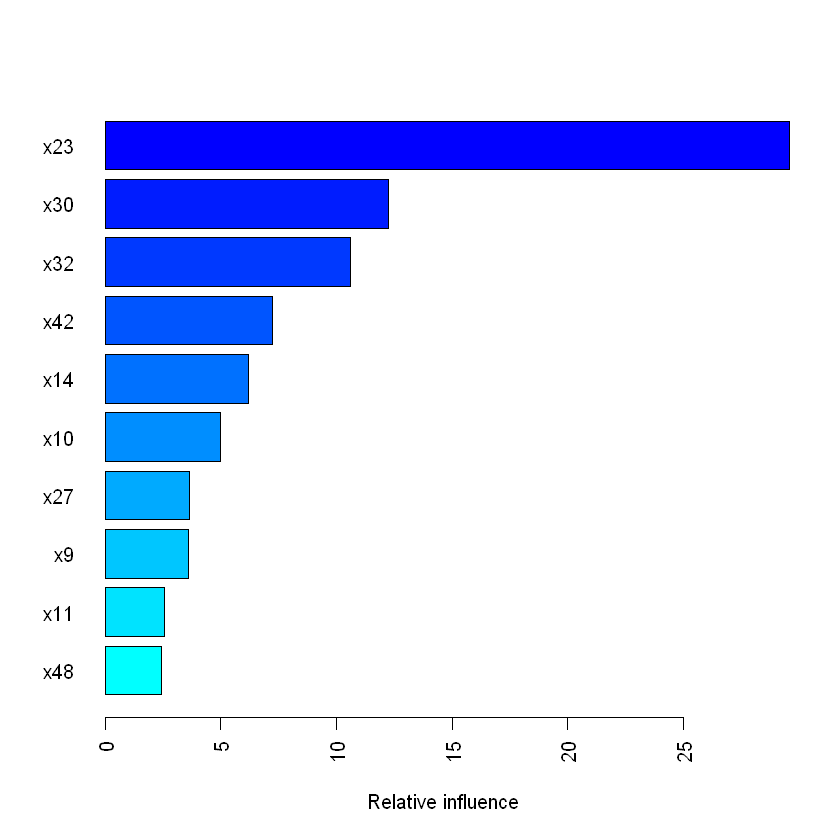

In [9]:
#summary of final model - most influencing parameters
summary(
 project_SGB_best$finalModel, 
  cBars = 10,
  method = relative.influence, # also can use permutation.test.gbm
  las = 2
  )
